## 0.- Imports necesarios para el clustering de los datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import json
import joblib
import plotly.express as px
import warnings 
from numpy import unique,where

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples

## 1.- Leer el fichero de datos de los pacientes con diabetes

Como en el análisis estadístico ya hemos limpiado y preprocesado el dataset solo tenemos que cargarlo y quedarnos con las variables relevantes

### 1.1.- Cargamos el fichero en la variable df

In [2]:
# Path al fichero de datos
file_path = 'diabetes_data_clean.csv'

# Leemos el fichero como un df de Pandas
df = pd.read_csv(file_path)

# Imprimimos la cabecera para ver si ha cargado
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


### 1.2.- Obeservamos dimensiones del dataset y los nombres de columnas con sus tipos

In [3]:
# Numero de filas y columnas en el df
filas, columnas = df.shape
print(f"Numero de filas: {filas}")
print(f"Numero de columnas: {columnas}")

Numero de filas: 229781
Numero de columnas: 22


In [4]:
# Nombres de las columnas
nombres_columnas = df.columns
print("Columnas del df:", nombres_columnas)

Columnas del df: Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


### 1.3.- Reducción del dataset

A diferencia del K means el resto de algorimtos requieren de mucha RAM, más de la que se puede emplear en el desarrollo de este TFM. Por ellos vamos a quedarnos con una muestra significativa del dataset con 4000 de cada categoria de diabetes a partir de ahora para hacer el clustering

In [5]:
# Función que coge un conjunto random de tamaño 5000 para cada grupo
def get_random_sample(group, n=5000):
    return group.sample(n=min(n, group.shape[0]), random_state=42)

clustering_df_original = copy.deepcopy(df)

df_sampled = df.groupby('Diabetes_012', group_keys=False).apply(get_random_sample, n=4000)

df_sampled.reset_index(inplace=True)


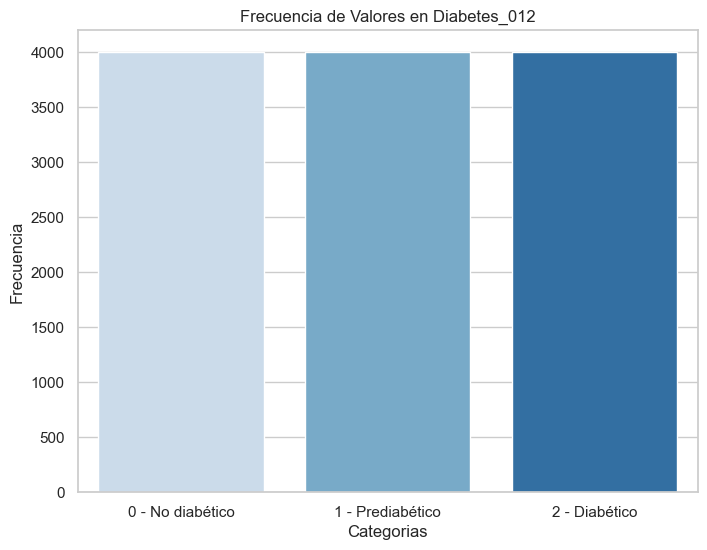

In [6]:
# Definimos un mapeo de etiquetas para los valores en 'Diabetes_012'
etiquetas = {0: 'No diabético', 1: 'Prediabético', 2: 'Diabético'}

# Cereamos una copia a modificar
df_graficas = df_sampled.copy()
df_graficas['Diabetes_012'] = df_graficas['Diabetes_012'].map(etiquetas)

# Gráfica de barras con barras estrechas, color azul, cuadrícula y leyenda
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.countplot(data=df_graficas, x='Diabetes_012', palette="Blues")
plt.title("Frecuencia de Valores en Diabetes_012")
plt.xlabel("Categorias")
plt.ylabel("Frecuencia")

# Personaliza la leyenda
legend_labels = [f"{key} - {value}" for key, value in etiquetas.items()]
ax.set_xticklabels(legend_labels)

plt.show()

In [7]:
print(df_sampled.value_counts("Diabetes_012"))
clustering_df = df_sampled.drop(columns=['Diabetes_012','index'])

clustering_df.to_csv('clustering_df_reducido.csv', index=False)

# Numero de filas y columnas en el df
filas, columnas = clustering_df.shape
print(f"Numero de filas: {filas}")
print(f"Numero de columnas: {columnas}")



Diabetes_012
0    4000
1    4000
2    4000
dtype: int64
Numero de filas: 12000
Numero de columnas: 21


## 2.- Definición del modelo KMeans (Basado en Centroides)

### 2.1.- Cálculo del número óptimo de clusters

Para KMeans como vemos en el estado del arte, el método más empleado para determinar el número de clusters es el de la inercia.

In [8]:
# Lista para almacenar las inercias
inertias = []

# Números de clusters para probar
k_values = range(1, 10)

# Ignoramos los warning
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
clustering_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,33,0,0,0,1,1,1,...,1,0,3,0,0,0,0,6,6,7
1,1,1,1,33,1,0,0,0,1,1,...,1,0,3,14,0,1,0,9,6,7
2,0,0,1,25,1,0,0,1,1,1,...,1,0,1,0,0,0,1,6,4,7
3,1,1,1,26,0,0,0,1,0,1,...,1,0,2,0,0,0,0,13,3,3
4,0,0,1,15,0,0,0,1,0,1,...,1,0,2,0,1,0,1,5,6,8


In [10]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

columnas_deseadas = ['MentHlth', 'PhysHlth', 'BMI']
clustering_df = clustering_df.loc[:, columnas_deseadas]

for k in k_values:
    Clusterer = Pipeline([
        ('MMS', MinMaxScaler()),
        ('kmeans', KMeans(n_clusters=k, random_state=42))
    ])
    
    # Entrenar el modelo
    Clusterer.fit(clustering_df)
    
    # Obtener la inercia y almacenarla en la lista
    inertias.append(Clusterer.named_steps['kmeans'].inertia_)

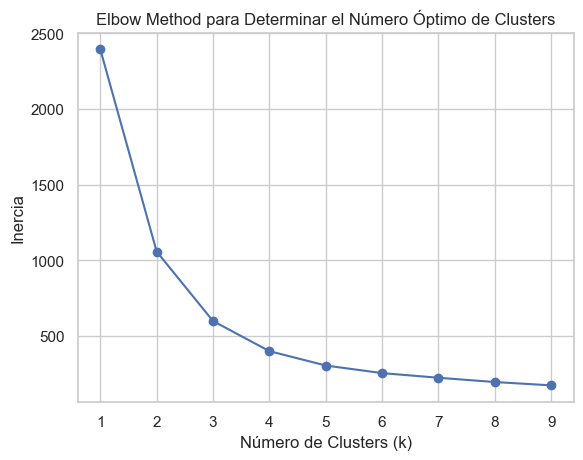

In [11]:
# Graficar la curva de la inercia en función del número de clusters para determinar el número óptimo
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Method para Determinar el Número Óptimo de Clusters')
plt.show()

### 2.2.- Definición de la pipeline para el KMeans

In [12]:
total_clusters = 3 # En base a la grafica anterior cogemos el codo de la misma 
kmeans_pipeline = Pipeline([
    ('MMS', MinMaxScaler()),
    ('kmeans', KMeans(n_clusters=total_clusters)) 
])

### 2.3.- Entrenamos el modelo con la pipeline y los datos del df

In [13]:
kmeans_pipeline.fit(clustering_df)

Pipeline(steps=[('MMS', MinMaxScaler()), ('kmeans', KMeans(n_clusters=3))])

### 2.4.- Obtenemos las etiquetas (Cluster al que pertenece) para cada dato

In [14]:
labels = kmeans_pipeline.predict(clustering_df)

### 2.5.- Agregar las etiquetas de clusters y de clasificacion al conjunto de datos


In [15]:
clustering_df["cluster_label"] = labels
clustering_df["diabetic_label"] = df_sampled["Diabetes_012"]

clustering_df.head()
clustering_df.to_csv('resultados/df_clusters/kmeans.csv')

### 2.6.- Resumen de pertenencia de clusters por grupo de diabetes

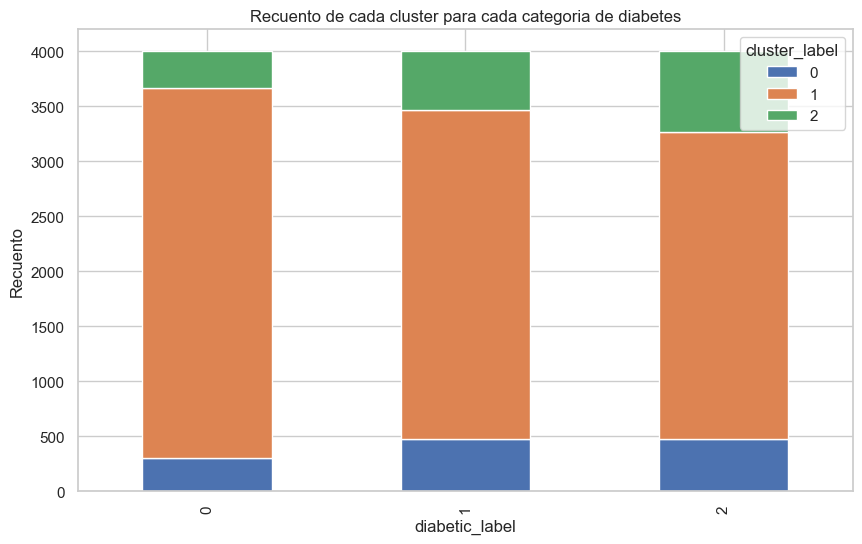

In [16]:

# Agrupa por 'diabetic_label' y 'cluster_label' y cuenta las ocurrencias
df_agrupado = clustering_df.groupby(['diabetic_label', 'cluster_label']).size().unstack()

# Crear el gráfico de barras
df_agrupado.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y etiquetas
plt.title('Recuento de cada cluster para cada categoria de diabetes')
plt.xlabel('diabetic_label')
plt.ylabel('Recuento')

# Mostrar el gráfico
plt.show()

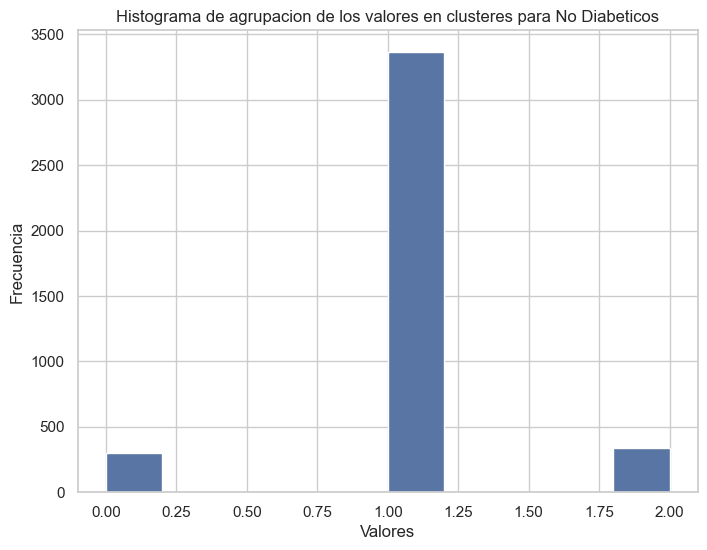

In [17]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 0]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para No Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

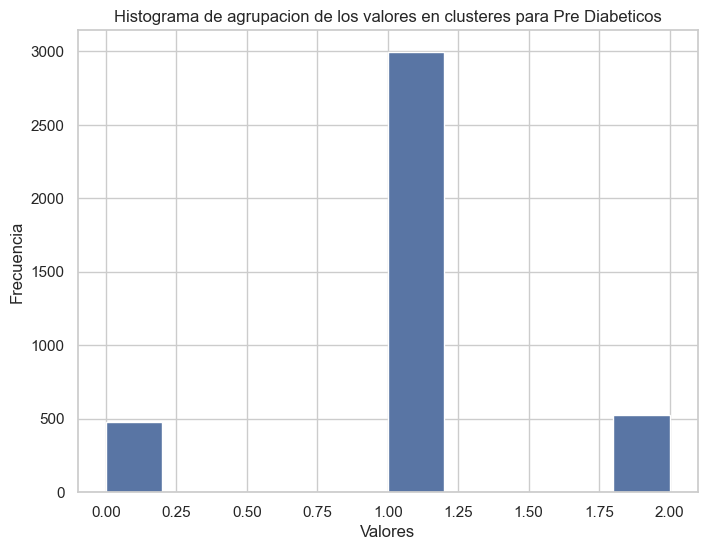

In [18]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 1]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para Pre Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

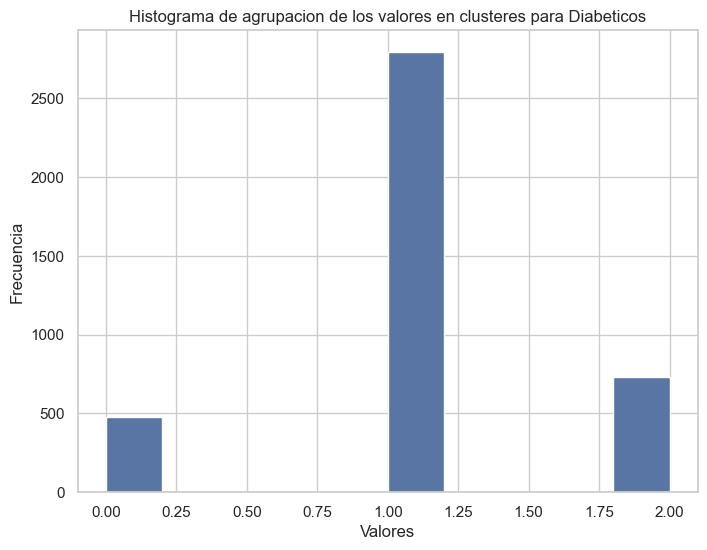

In [19]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 2]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

### 2.7.- Resumen general de pertenencia de las categorias de diabetes a los clusters

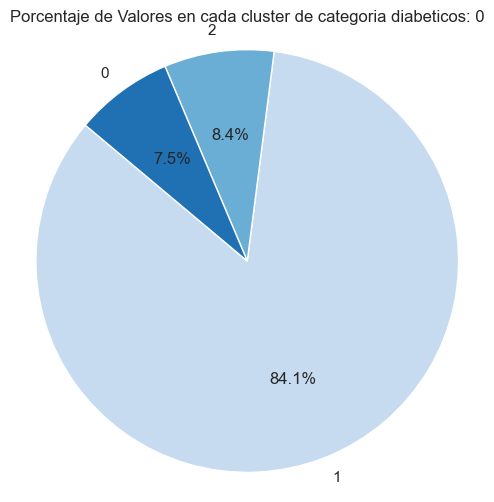

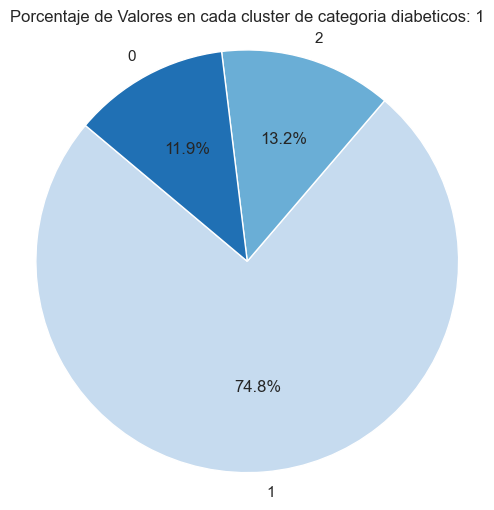

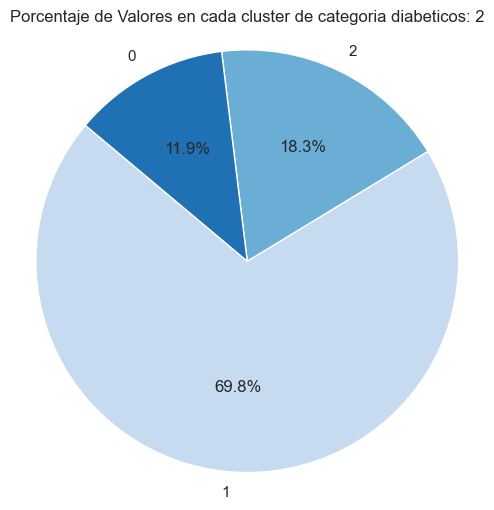

In [20]:
for diabetic_value in clustering_df['diabetic_label'].unique():
    
    # Pintamos el pie plot para esta categoria de diabetes
    df_class =  clustering_df[clustering_df['diabetic_label'] == diabetic_value]
    plt.figure(figsize=(6, 6))
    labels = df_class['cluster_label'].value_counts().index
    sizes = df_class['cluster_label'].value_counts().values
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Blues", n_colors=total_clusters))
    plt.title(f"Porcentaje de Valores en cada cluster de categoria diabeticos: {diabetic_value}")
    plt.axis('equal') 
    plt.show()

    

### 2.8.- Análisis estadístico de los clusters

In [21]:
for cluster_number in list(range(total_clusters)):
    # Guardamos las descripción a un csv
    description_df = clustering_df[clustering_df['cluster_label'] == cluster_number].drop(columns=['diabetic_label', 'cluster_label']).describe()
    description_df.to_csv(f'resultados\\kmeans\\kmeans_estadisticas_cluster{cluster_number}.csv', sep=',', float_format='%.2f', index=False)

    # Guardamos la moda a un csv
    mode_df = clustering_df[clustering_df['cluster_label'] == cluster_number].drop(columns=['diabetic_label', 'cluster_label']).mode()
    mode_df.to_csv(f'resultados\\kmeans\\kmeans_moda_cluster{cluster_number}.csv', sep=',', float_format='%.2f', index=False)


### 2.9.- Representamos los clusters para cada categoría de enfermedad y las tres variables deseadas

Escogemos tres pero podrían ser cualquiera del dataset

In [22]:
# Variables a comparar
var1 = "MentHlth"
var2 = "PhysHlth"
var3 = "BMI"

#### 2.10.1.- No diabetico 3D Plot

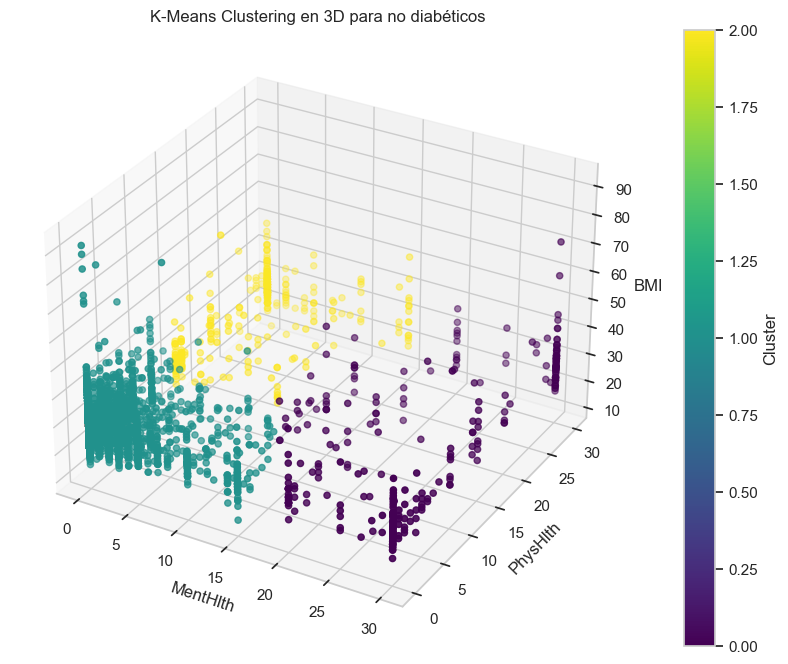

In [23]:
# Filtramos los no diabeticos
clustering_df_filtrado = clustering_df[clustering_df['diabetic_label'] == 0]

# Creamos una figura 3D
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(clustering_df_filtrado[var1], clustering_df_filtrado[var2], clustering_df_filtrado[var3], c=clustering_df_filtrado["cluster_label"], cmap='viridis', marker='o')

# Añadimos etiquetas y titulos
ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)
ax.set_title('K-Means Clustering en 3D para no diabéticos')

# añadimos leyenda de clusteres como barra de colores
fig.colorbar(scatter, ax=ax, label='Cluster')

# Mostramos la gráfica
plt.show()

#### 2.10.2.- Pre diabetico 3D Plot

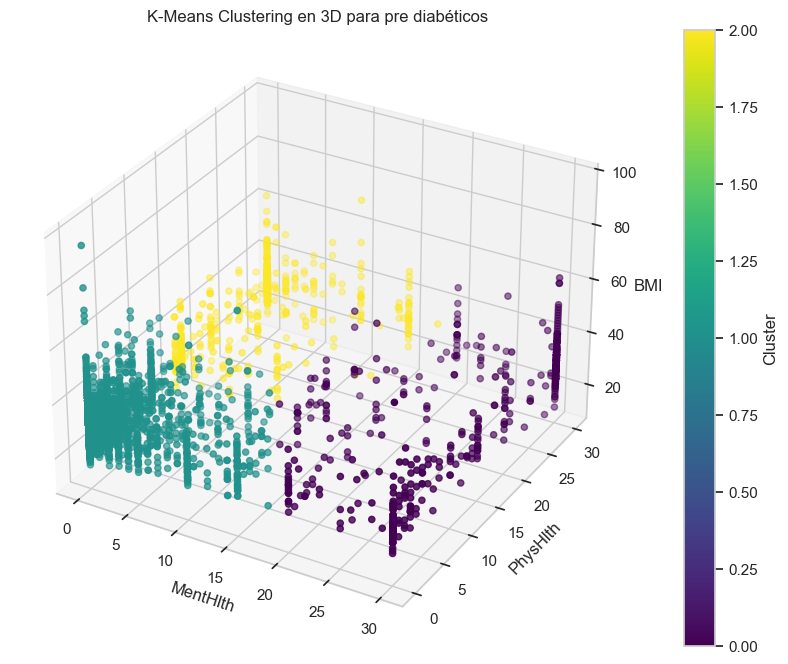

In [24]:
# Filtramos los pre diabeticos
clustering_df_filtrado = clustering_df[clustering_df['diabetic_label'] == 1]

# Creamos una figura 3D
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(clustering_df_filtrado[var1], clustering_df_filtrado[var2], clustering_df_filtrado[var3], c=clustering_df_filtrado["cluster_label"], cmap='viridis', marker='o')

# Añadimos etiquetas y titulos
ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)
ax.set_title('K-Means Clustering en 3D para pre diabéticos')

# añadimos leyenda de clusteres como barra de colores
fig.colorbar(scatter, ax=ax, label='Cluster')

# Mostramos la gráfica
plt.show()

#### 2.10.3.- Diabetico 3D Plot

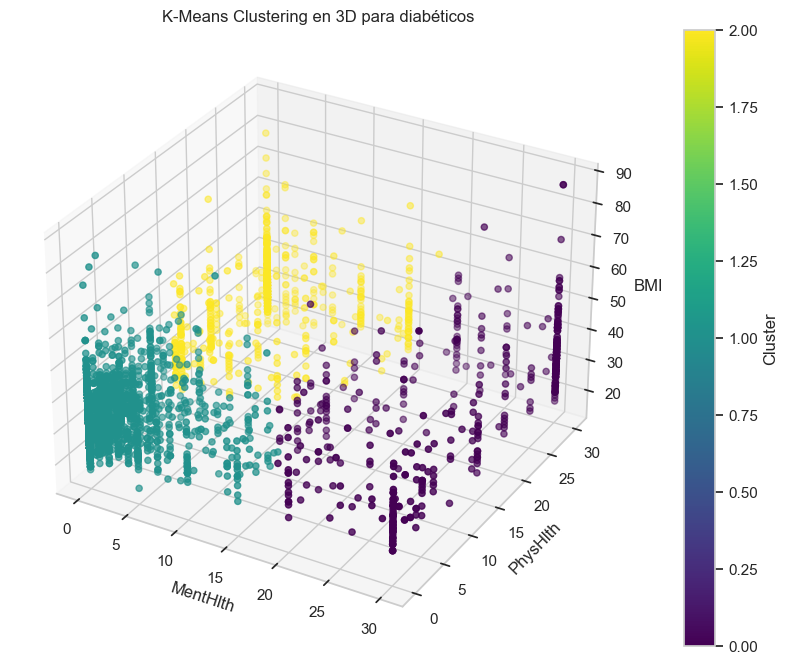

In [25]:
# Filtramos los diabeticos
clustering_df_filtrado = clustering_df[clustering_df['diabetic_label'] == 2]

# Creamos una figura 3D
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(clustering_df_filtrado[var1], clustering_df_filtrado[var2], clustering_df_filtrado[var3], c=clustering_df_filtrado["cluster_label"], cmap='viridis', marker='o')

# Añadimos etiquetas y titulos
ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)
ax.set_title('K-Means Clustering en 3D para diabéticos')

# añadimos leyenda de clusteres como barra de colores
fig.colorbar(scatter, ax=ax, label='Cluster')

# Mostramos la gráfica
plt.show()

### 2.10.- Evaluación de calidad

In [26]:
evaluacion_calidad = {}

In [27]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

# Indice de silueta
silhouette_avg = silhouette_score(clustering_df, kmeans_pipeline.named_steps['kmeans'].labels_)
print("El índice de silueta promedio es:", silhouette_avg)

# Indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(clustering_df, kmeans_pipeline.named_steps['kmeans'].labels_)
print("El índice de Davies-Bouldin es:", davies_bouldin)

evaluacion_calidad["kmeans"] = {"silueta": silhouette_avg, "davies_bouldin": davies_bouldin}

El índice de silueta promedio es: 0.5261373140682846
El índice de Davies-Bouldin es: 0.9704896757029348


El índice de silueta es una medida de qué tan bien están separados los clusters en un conjunto de datos. Toma valores en el rango [-1, 1]. Cuanto más cercano a 1 sea el valor, mejor será la separación, indicando que los puntos están bien ubicados en sus clusters y lejos de los otros clusters. Un valor cercano a 0 indica superposición en la ubicación de los clusters, mientras que valores negativos generalmente indican que los puntos podrían estar asignados al cluster incorrecto.

El índice de Davies-Bouldin es otra métrica de validación interna para evaluar la calidad de los clusters. Mide la "compacidad" dentro de los clusters y la separación entre diferentes clusters. Un valor más bajo indica una mejor partición.

In [28]:
cluster_siluetes = {}

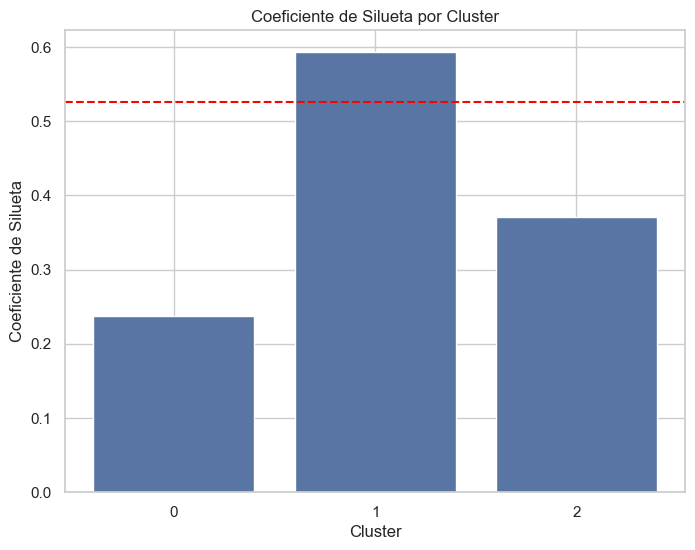

In [29]:
# Calculamos el coeficiente de Silueta promedio
silhouette_avg = silhouette_score(clustering_df, kmeans_pipeline.named_steps['kmeans'].labels_)

# Calculamos el coeficiente de Silueta para cada muestra
sample_silhouette_values = silhouette_samples(clustering_df, kmeans_pipeline.named_steps['kmeans'].labels_)

# Creamos una lista para almacenar los coeficientes de Silueta promedio por cluster
cluster_silhouette_avg = []

list_siluetes = []
# Creamos un bucle para obtener el coeficiente de Silueta para cada cluster
for cluster in range(max(kmeans_pipeline.named_steps['kmeans'].labels_)+1):
    # Obtenemos las muestras pertenecientes al cluster actual
    cluster_silhouette_values = sample_silhouette_values[kmeans_pipeline.named_steps['kmeans'].labels_ == cluster]
    
    # Calculamos el coeficiente de Silueta promedio para el cluster actual
    avg_silhouette = np.mean(cluster_silhouette_values)
    
    cluster_dict = {'category': cluster, 'value': avg_silhouette}
    list_siluetes.append(cluster_dict)

    # Almacenamos el coeficiente de Silueta promedio en la lista
    cluster_silhouette_avg.append(avg_silhouette)

cluster_siluetes["kmeans"] = list_siluetes

# Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_silhouette_avg)), cluster_silhouette_avg, color="#5975A4")
plt.title('Coeficiente de Silueta por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(range(len(cluster_silhouette_avg)))
plt.axhline(y=silhouette_avg, color="red", linestyle="--")  # Línea para indicar el valor promedio global de Silueta
plt.show()

### 2.11.- Save models

In [30]:
joblib.dump(kmeans_pipeline, 'resultados/trained_models/kmeans.joblib')

['resultados/trained_models/kmeans.joblib']

In [31]:
clustering_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,33,0,0,0,1,1,1,...,1,0,3,0,0,0,0,6,6,7
1,1,1,1,33,1,0,0,0,1,1,...,1,0,3,14,0,1,0,9,6,7
2,0,0,1,25,1,0,0,1,1,1,...,1,0,1,0,0,0,1,6,4,7
3,1,1,1,26,0,0,0,1,0,1,...,1,0,2,0,0,0,0,13,3,3
4,0,0,1,15,0,0,0,1,0,1,...,1,0,2,0,1,0,1,5,6,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,1,1,1,29,1,0,0,0,1,0,...,1,0,4,0,0,1,1,12,2,2
11996,1,1,1,17,1,0,1,0,0,0,...,1,1,5,2,4,1,1,8,3,1
11997,0,0,1,22,1,0,0,0,1,1,...,1,0,4,0,30,1,1,13,4,5
11998,1,1,1,27,0,0,1,1,1,1,...,0,0,4,0,0,1,0,13,4,1


## 3.- KMedoids (Basado en Centroides)

### 3.1.- Cálculo del número óptimo de clusters

In [32]:
# Lista para almacenar las inercias
inertias = []

# Números de clusters para probar
k_values = range(3, 10)

# Ignoramos los warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [33]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

columnas_deseadas = ['MentHlth', 'PhysHlth', 'BMI']
clustering_df = clustering_df.loc[:, columnas_deseadas]

for k in k_values:
    Clusterer = Pipeline([
        ('MMS', MinMaxScaler()),
        ('kmedoids', KMedoids(n_clusters=k, random_state=42))
    ])
    
    # Entrenar el modelo
    Clusterer.fit(clustering_df)
    
    # Obtener la inercia y almacenarla en la lista
    inertias.append(Clusterer.named_steps['kmedoids'].inertia_)

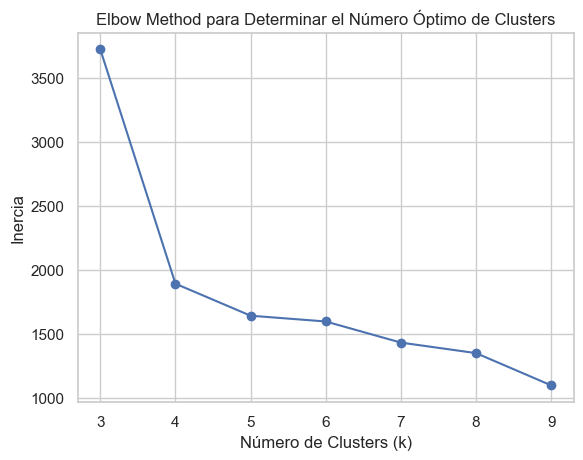

In [34]:
# Graficar la curva de la inercia en función del número de clusters para determinar el número óptimo
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Method para Determinar el Número Óptimo de Clusters')
plt.show()

### 3.2.- Definición de la pipeline para el KMedoids

In [35]:
total_clusters = 4 # En base a la grafica anterior cogemos el codo de la misma 
kmedoids_pipeline = Pipeline([
    ('MMS', MinMaxScaler()),
    ('kmedoids', KMedoids(n_clusters=total_clusters)) 
])

### 3.3.- Entrenamos el modelo con la pipeline y los datos del df

In [36]:
kmedoids_pipeline.fit(clustering_df)

Pipeline(steps=[('MMS', MinMaxScaler()), ('kmedoids', KMedoids(n_clusters=4))])

### 3.4.- Obtenemos las etiquetas (Cluster al que pertenece) para cada dato

In [37]:
labels = kmedoids_pipeline.predict(clustering_df)

### 3.5.- Agregar las etiquetas de clusters y de clasificacion al conjunto de datos

In [38]:
clustering_df["cluster_label"] = labels
clustering_df["diabetic_label"] = df_sampled["Diabetes_012"]

clustering_df.head()
clustering_df.to_csv('resultados/df_clusters/kmedoids.csv')

### 3.6.- Resumen de pertenencia de clusters por grupo de diabetes

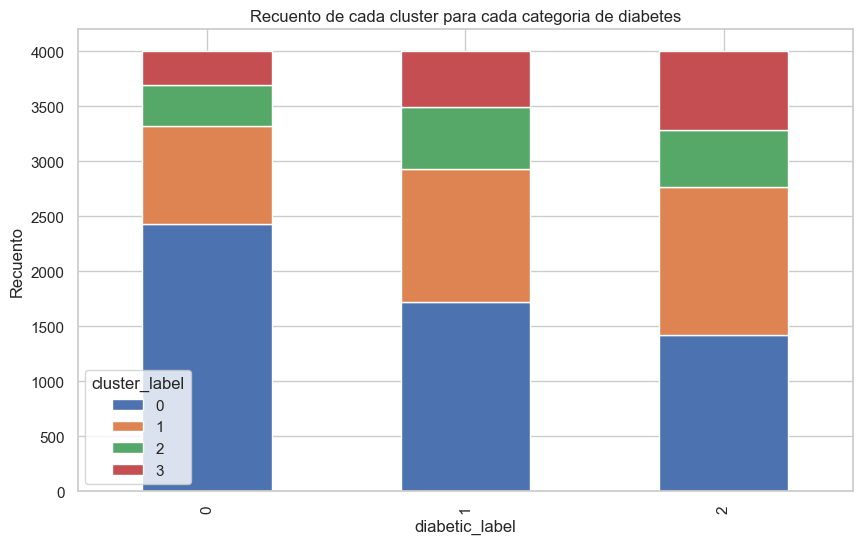

In [39]:

# Agrupa por 'diabetic_label' y 'cluster_label' y cuenta las ocurrencias
df_agrupado = clustering_df.groupby(['diabetic_label', 'cluster_label']).size().unstack()

# Crear el gráfico de barras
df_agrupado.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y etiquetas
plt.title('Recuento de cada cluster para cada categoria de diabetes')
plt.xlabel('diabetic_label')
plt.ylabel('Recuento')

# Mostrar el gráfico
plt.show()

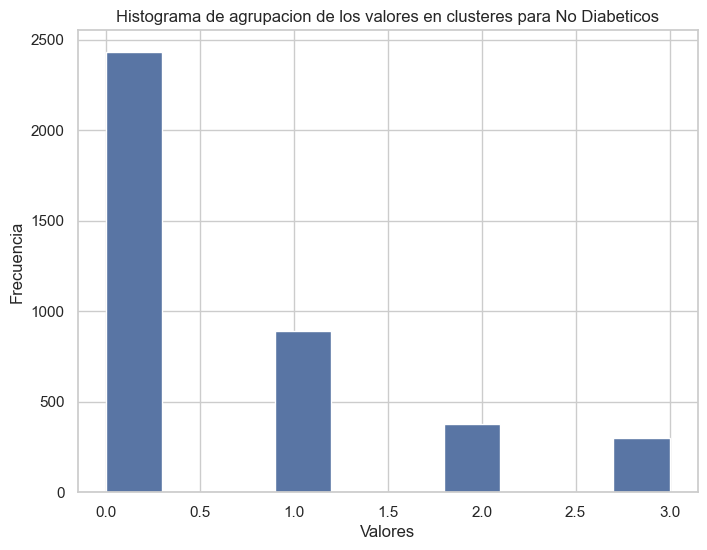

In [40]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 0]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para No Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

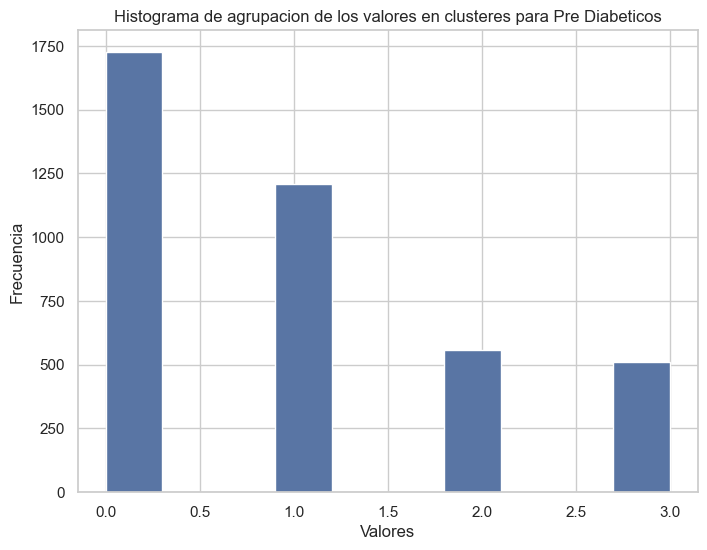

In [41]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 1]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para Pre Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

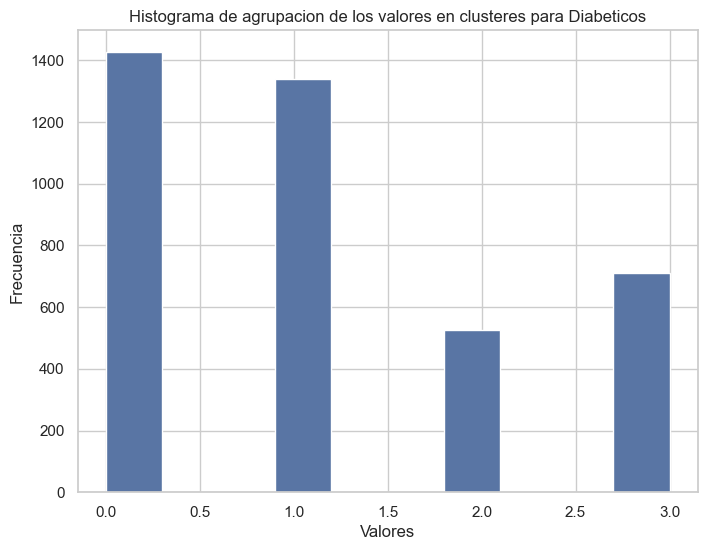

In [42]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 2]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

### 3.7.- Resumen general de pertenencia de las categorias de diabetes a los clusters

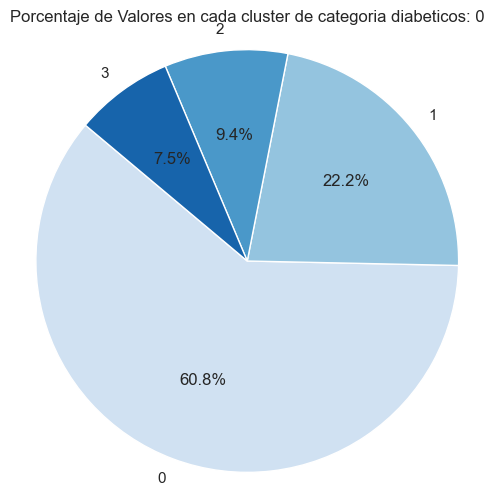

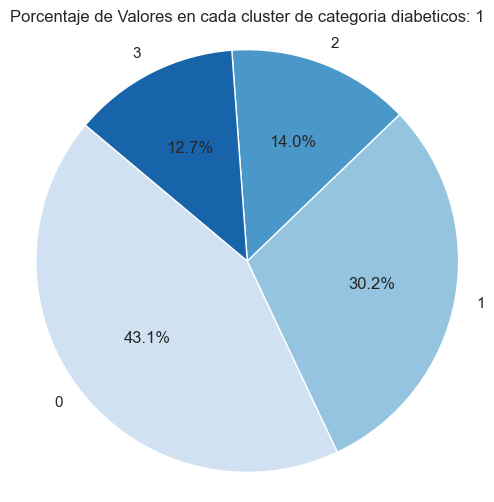

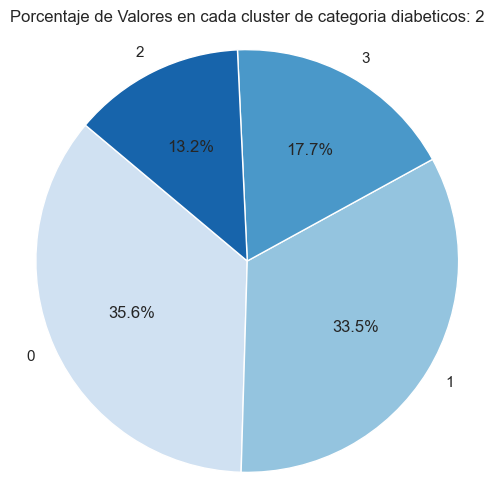

In [43]:
for diabetic_value in clustering_df['diabetic_label'].unique():
    
    # Pintamos el pie plot para esta categoria de diabetes
    df_class =  clustering_df[clustering_df['diabetic_label'] == diabetic_value]
    plt.figure(figsize=(6, 6))
    labels = df_class['cluster_label'].value_counts().index
    sizes = df_class['cluster_label'].value_counts().values
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Blues", n_colors=total_clusters))
    plt.title(f"Porcentaje de Valores en cada cluster de categoria diabeticos: {diabetic_value}")
    plt.axis('equal') 
    plt.show()

### 3.8.- Análisis estadístico de los clusters

In [44]:
for cluster_number in list(range(total_clusters)):
    # Guardamos las descripción a un csv
    description_df = clustering_df[clustering_df['cluster_label'] == cluster_number].drop(columns=['diabetic_label', 'cluster_label']).describe()
    description_df.to_csv(f'resultados\\kmedoids\\kmedoids_estadisticas_cluster{cluster_number}.csv', sep=',', float_format='%.2f', index=False)

    # Guardamos la moda a un csv
    mode_df = clustering_df[clustering_df['cluster_label'] == cluster_number].drop(columns=['diabetic_label', 'cluster_label']).mode()
    mode_df.to_csv(f'resultados\\kmedoids\\kmedoids_moda_cluster{cluster_number}.csv', sep=',', float_format='%.2f', index=False)

### 3.9.- Representamos los clusters para cada categoría de enfermedad y las tres variables deseadas

Escogemos tres pero podrían ser cualquiera del dataset

In [45]:
# Variables a comparar
var1 = "MentHlth"
var2 = "PhysHlth"
var3 = "BMI"

#### 3.9.1.- No diabetico 3D Plot

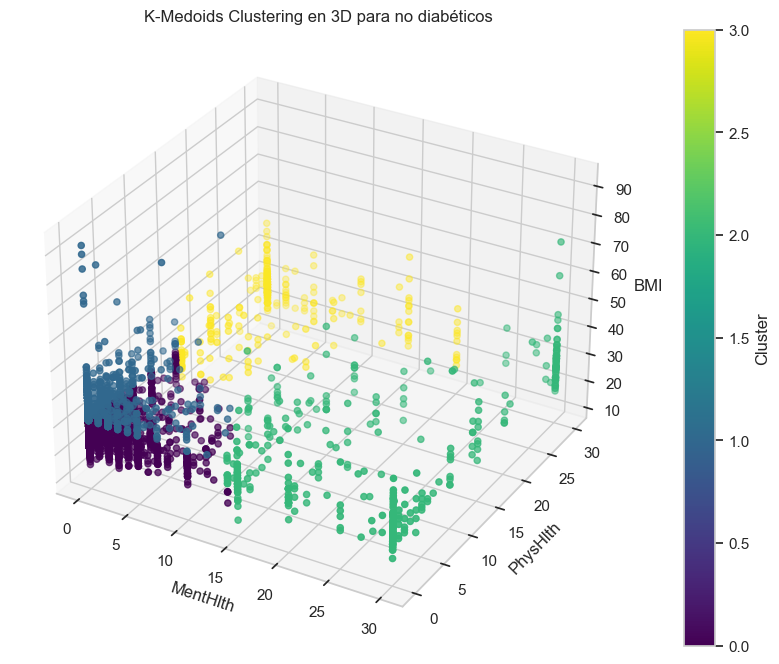

In [46]:
# Filtramos los no diabeticos
clustering_df_filtrado = clustering_df[clustering_df['diabetic_label'] == 0]

# Creamos una figura 3D
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(clustering_df_filtrado[var1], clustering_df_filtrado[var2], clustering_df_filtrado[var3], c=clustering_df_filtrado["cluster_label"], cmap='viridis', marker='o')

# Añadimos etiquetas y titulos
ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)
ax.set_title('K-Medoids Clustering en 3D para no diabéticos')

# añadimos leyenda de clusteres como barra de colores
fig.colorbar(scatter, ax=ax, label='Cluster')

# Mostramos la gráfica
plt.show()

#### 3.9.2.- Pre diabetico 3D Plot

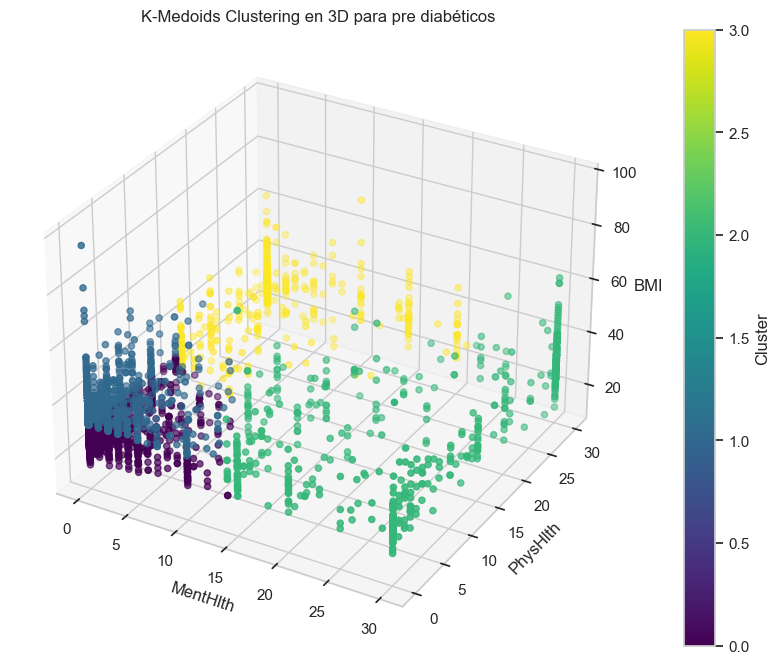

In [47]:
# Filtramos los pre diabeticos
clustering_df_filtrado = clustering_df[clustering_df['diabetic_label'] == 1]

# Creamos una figura 3D
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(clustering_df_filtrado[var1], clustering_df_filtrado[var2], clustering_df_filtrado[var3], c=clustering_df_filtrado["cluster_label"], cmap='viridis', marker='o')

# Añadimos etiquetas y titulos
ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)
ax.set_title('K-Medoids Clustering en 3D para pre diabéticos')

# añadimos leyenda de clusteres como barra de colores
fig.colorbar(scatter, ax=ax, label='Cluster')

# Mostramos la gráfica
plt.show()

#### 3.9.3.- Diabetico 3D Plot

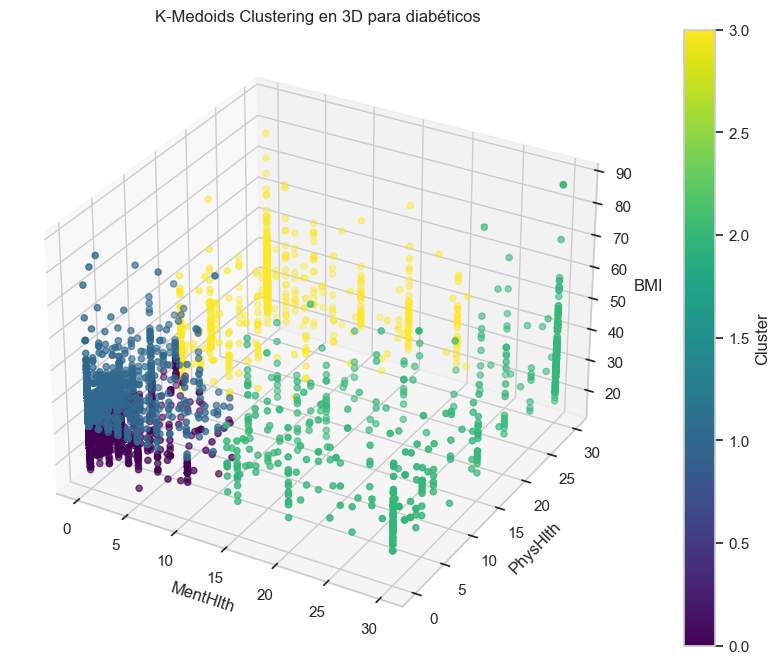

In [48]:
# Filtramos los diabeticos
clustering_df_filtrado = clustering_df[clustering_df['diabetic_label'] == 2]

# Creamos una figura 3D
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(clustering_df_filtrado[var1], clustering_df_filtrado[var2], clustering_df_filtrado[var3], c=clustering_df_filtrado["cluster_label"], cmap='viridis', marker='o')

# Añadimos etiquetas y titulos
ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)
ax.set_title('K-Medoids Clustering en 3D para diabéticos')

# añadimos leyenda de clusteres como barra de colores
fig.colorbar(scatter, ax=ax, label='Cluster')

# Mostramos la gráfica
plt.show()

### 3.10.- Evaluación de calidad

In [49]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

# Indice de silueta
silhouette_avg = silhouette_score(clustering_df, kmedoids_pipeline.named_steps['kmedoids'].labels_)
print("El índice de silueta promedio es:", silhouette_avg)

# Indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(clustering_df, kmedoids_pipeline.named_steps['kmedoids'].labels_)
print("El índice de Davies-Bouldin es:", davies_bouldin)

evaluacion_calidad["kmedoids"] = {"silueta": silhouette_avg, "davies_bouldin": davies_bouldin}

El índice de silueta promedio es: 0.2991221312391194
El índice de Davies-Bouldin es: 1.1530872792512559


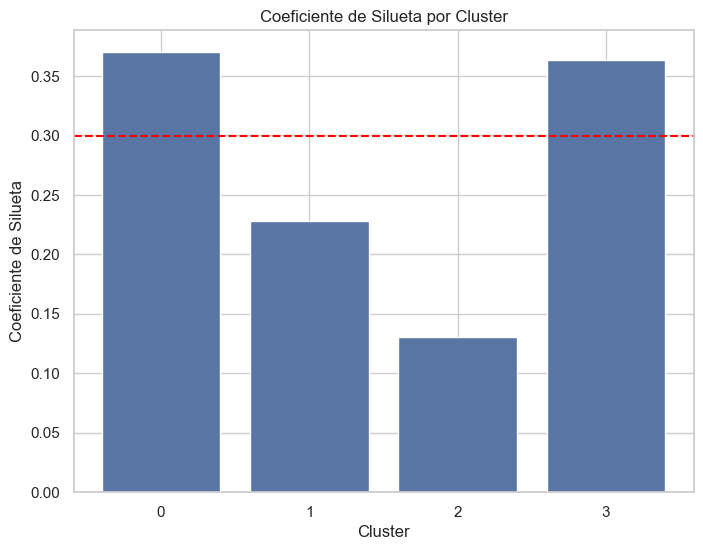

In [50]:
# Calculamos el coeficiente de Silueta promedio
silhouette_avg = silhouette_score(clustering_df, kmedoids_pipeline.named_steps['kmedoids'].labels_)

# Calculamos el coeficiente de Silueta para cada muestra
sample_silhouette_values = silhouette_samples(clustering_df, kmedoids_pipeline.named_steps['kmedoids'].labels_)

# Creamos una lista para almacenar los coeficientes de Silueta promedio por cluster
cluster_silhouette_avg = []

list_siluetes = []
# Creamos un bucle para obtener el coeficiente de Silueta para cada cluster
for cluster in range(max(kmedoids_pipeline.named_steps['kmedoids'].labels_)+1):
    # Obtenemos las muestras pertenecientes al cluster actual
    cluster_silhouette_values = sample_silhouette_values[kmedoids_pipeline.named_steps['kmedoids'].labels_ == cluster]
    
    # Calculamos el coeficiente de Silueta promedio para el cluster actual
    avg_silhouette = np.mean(cluster_silhouette_values)
    
    cluster_dict = {'category': cluster, 'value': avg_silhouette}
    list_siluetes.append(cluster_dict)

    # Almacenamos el coeficiente de Silueta promedio en la lista
    cluster_silhouette_avg.append(avg_silhouette)

cluster_siluetes["kmedoids"] = list_siluetes

# Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_silhouette_avg)), cluster_silhouette_avg, color="#5975A4")
plt.title('Coeficiente de Silueta por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(range(len(cluster_silhouette_avg)))
plt.axhline(y=silhouette_avg, color="red", linestyle="--")  # Línea para indicar el valor promedio global de Silueta
plt.show()

### 3.11.- Save Models

In [51]:
joblib.dump(Clusterer, 'resultados/trained_models/kmedoids.joblib')

['resultados/trained_models/kmedoids.joblib']

## 4.- AffinityPropagation (Basado en el concepto de "mensajeo")

 A diferencia de algoritmos de clusterización como k-means o k-medoids, propagación de afinidad no requiere que el número de grupos estén determinados o estimados antes de correr el algoritmo. 

### 4.1.- Definición de la pipeline para el AffinityPropagation

In [52]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

columnas_deseadas = ['MentHlth', 'PhysHlth', 'BMI']
clustering_df = clustering_df.loc[:, columnas_deseadas]

ap_pipeline = Pipeline([
    ('MMS', MinMaxScaler()),
    ('ap', AffinityPropagation(damping=0.7)) 
])

### 4.2.- Entrenamos el modelo con la pipeline y los datos del df

In [53]:
ap_pipeline.fit(clustering_df)

Pipeline(steps=[('MMS', MinMaxScaler()),
                ('ap', AffinityPropagation(damping=0.7))])

### 4.3.- Obtenemos las etiquetas (Cluster al que pertenece) para cada dato

In [54]:
labels = ap_pipeline.predict(clustering_df)

### 4.4.- Agregar las etiquetas de clusters y de clasificacion al conjunto de datos

In [55]:
clustering_df["cluster_label"] = labels
clustering_df["diabetic_label"] = df_sampled["Diabetes_012"]

clustering_df.head()
clustering_df.to_csv('resultados/df_clusters/affinitypropagation.csv')

### 4.5.- Número de clusters encontrados por el algoritmo

In [56]:
# Miramos el número de clusters que el algoritmo ha encontrado
clusters = unique(labels)
print(f"Numero de clusters: {len(clusters)}")

Numero de clusters: 284


### 4.6.- Resumen de pertenencia de clusters por grupo de diabetes

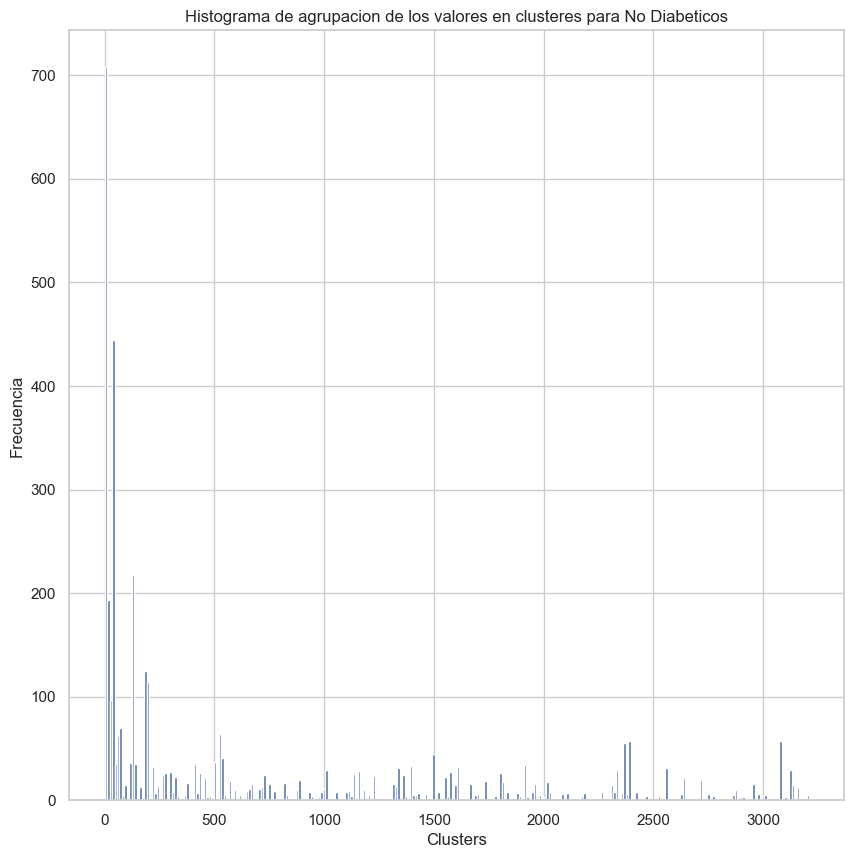

In [57]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 0]['cluster_label'] 
plt.figure(figsize=(10, 10))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para No Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()


# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 0],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

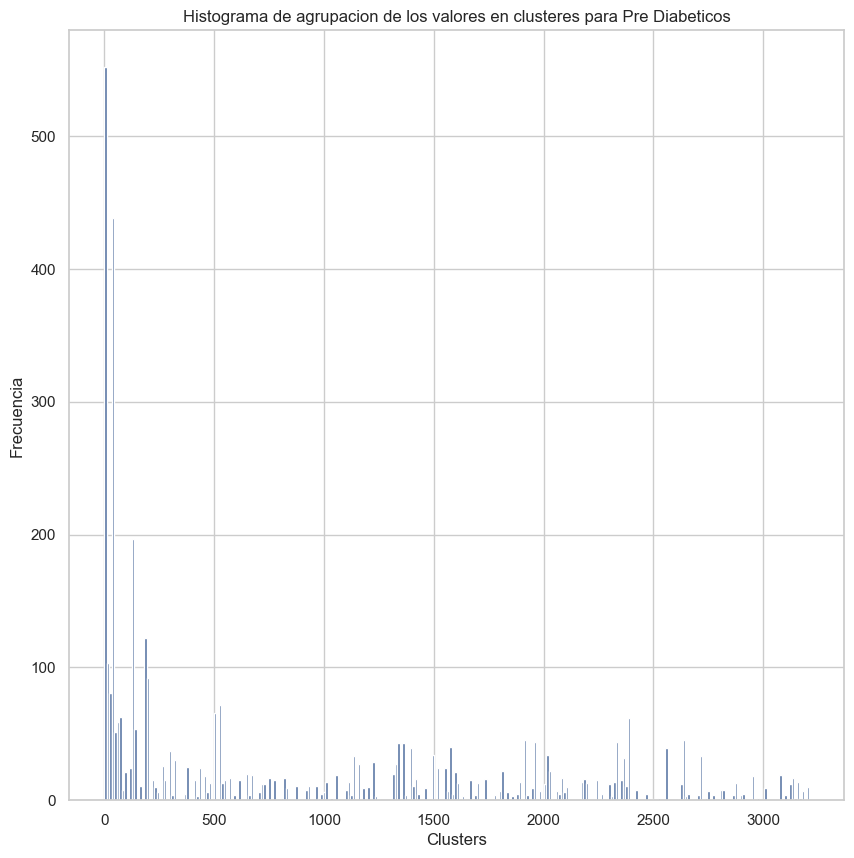

In [58]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 1]['cluster_label']
plt.figure(figsize=(10, 10))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para Pre Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 1],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

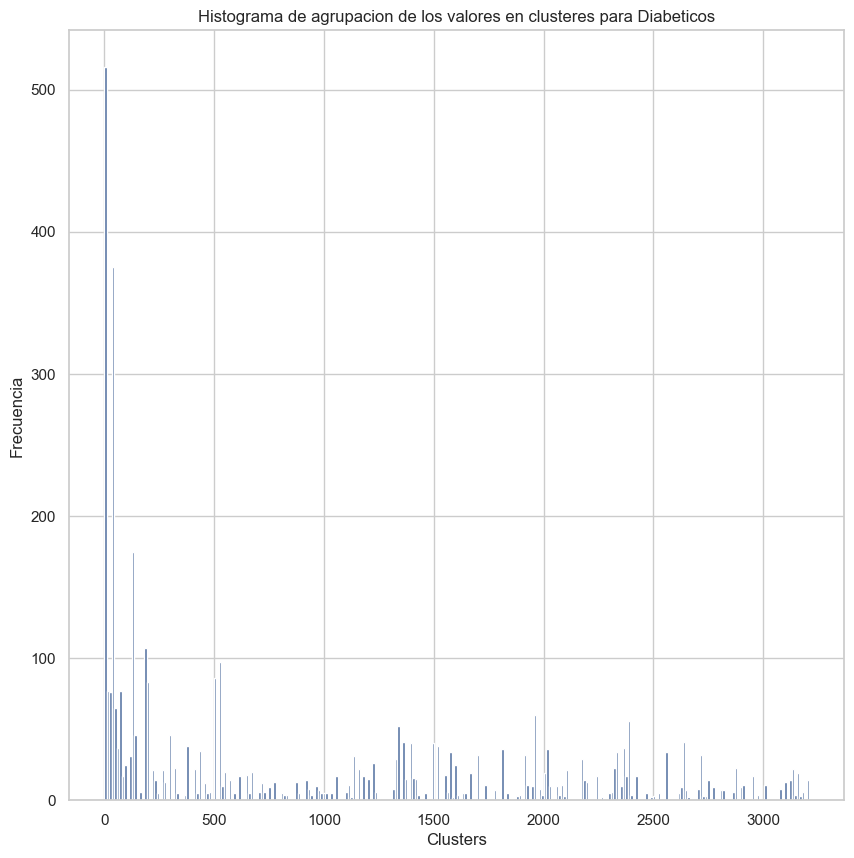

In [59]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 2]['cluster_label']
plt.figure(figsize=(10, 10))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 2],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

### 4.7.- Evaluación de calidad

In [60]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

# Indice de silueta
silhouette_avg = silhouette_score(clustering_df, ap_pipeline.named_steps['ap'].labels_)
print("El índice de silueta promedio es:", silhouette_avg)

# Indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(clustering_df, ap_pipeline.named_steps['ap'].labels_)
print("El índice de Davies-Bouldin es:", davies_bouldin)

evaluacion_calidad["affinitypropagation"] = {"silueta": silhouette_avg, "davies_bouldin": davies_bouldin}

El índice de silueta promedio es: -0.2356539244826847
El índice de Davies-Bouldin es: 3.1002663310808183


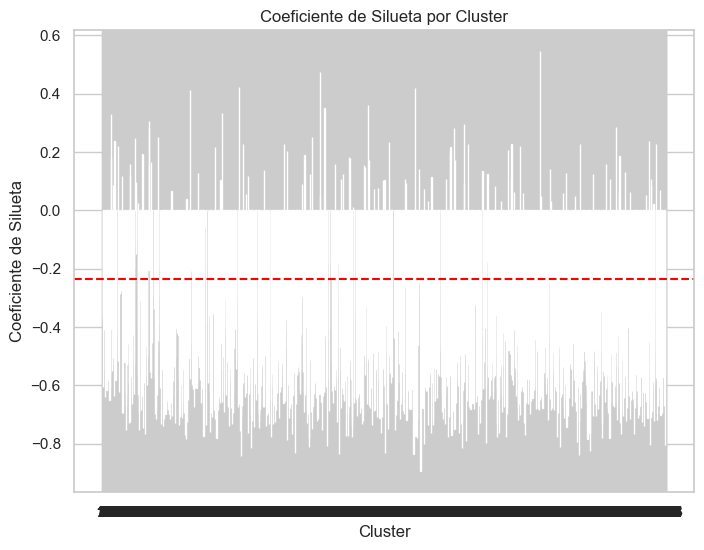

In [61]:
# Calculamos el coeficiente de Silueta promedio
silhouette_avg = silhouette_score(clustering_df, ap_pipeline.named_steps['ap'].labels_)

# Calculamos el coeficiente de Silueta para cada muestra
sample_silhouette_values = silhouette_samples(clustering_df, ap_pipeline.named_steps['ap'].labels_)

# Creamos una lista para almacenar los coeficientes de Silueta promedio por cluster
cluster_silhouette_avg = []

list_siluetes = []
# Creamos un bucle para obtener el coeficiente de Silueta para cada cluster
for cluster in range(max(ap_pipeline.named_steps['ap'].labels_)+1):
    # Obtenemos las muestras pertenecientes al cluster actual
    cluster_silhouette_values = sample_silhouette_values[ap_pipeline.named_steps['ap'].labels_ == cluster]
    
    # Calculamos el coeficiente de Silueta promedio para el cluster actual
    avg_silhouette = np.mean(cluster_silhouette_values)
    
    cluster_dict = {'category': cluster, 'value': avg_silhouette}
    list_siluetes.append(cluster_dict)

    # Almacenamos el coeficiente de Silueta promedio en la lista
    cluster_silhouette_avg.append(avg_silhouette)

cluster_siluetes["affinitypropagation"] = list_siluetes

# Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_silhouette_avg)-1), cluster_silhouette_avg[1:], color="#5975A4")
plt.title('Coeficiente de Silueta por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(range(len(cluster_silhouette_avg)))
plt.axhline(y=silhouette_avg, color="red", linestyle="--")  # Línea para indicar el valor promedio global de Silueta
plt.show()

### 4.8.- Save Models

In [62]:
joblib.dump(ap_pipeline, 'resultados/trained_models/affinitypropagation.joblib')

['resultados/trained_models/affinitypropagation.joblib']

## 5.- OPTICS  (Basado en el concepto de "Reachability Distance")

### 5.1.- Definición de la pipeline para el OPTICS

In [63]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

columnas_deseadas = ['MentHlth', 'PhysHlth', 'BMI']
clustering_df = clustering_df.loc[:, columnas_deseadas]

optics_pipeline = Pipeline([
    ('MMS', MinMaxScaler()),
    ('optics', OPTICS(eps=0.75, min_samples=20)) 
])

### 5.2.- Entrenamos el modelo con la pipeline y los datos del df

In [64]:
optics_pipeline.fit(clustering_df)

C:\Users\Marcos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning:

divide by zero encountered in divide



Pipeline(steps=[('MMS', MinMaxScaler()),
                ('optics', OPTICS(eps=0.75, min_samples=20))])

### 5.3.- Obtenemos las etiquetas (Cluster al que pertenece) para cada dato

In [65]:
labels = optics_pipeline.fit_predict(clustering_df)

C:\Users\Marcos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning:

divide by zero encountered in divide



### 5.4.- Agregar las etiquetas de clusters y de clasificacion al conjunto de datos

In [66]:
clustering_df["cluster_label"] = labels
clustering_df["diabetic_label"] = df_sampled["Diabetes_012"]

clustering_df.head()
clustering_df.to_csv('resultados/df_clusters/optics.csv')

### 5.5.- Número de clusters encontrados por el algoritmo
Cuando el algoritmo OPTICS asigna un punto a un cluster con un valor de -1, significa que ese punto puede ser considerado como un "punto de ruido" o un outlier. En términos de distancia, un valor de -1 indica que el punto está fuera del alcance de los clusters identificados, por lo que no pertenece claramente a ningún cluster específico.

In [67]:
# Miramos el número de clusters que el algoritmo ha encontrado
clusters = unique(labels)
print(f"Numero de clusters: {len(clusters)}")

# Numero de outliers
outlayers = len(clustering_df[clustering_df['cluster_label'] == -1])
print(f"Numero de outlayers: {outlayers}")

Numero de clusters: 101
Numero de outlayers: 3943


### 5.6.- Resumen de pertenencia de clusters por grupo de diabetes

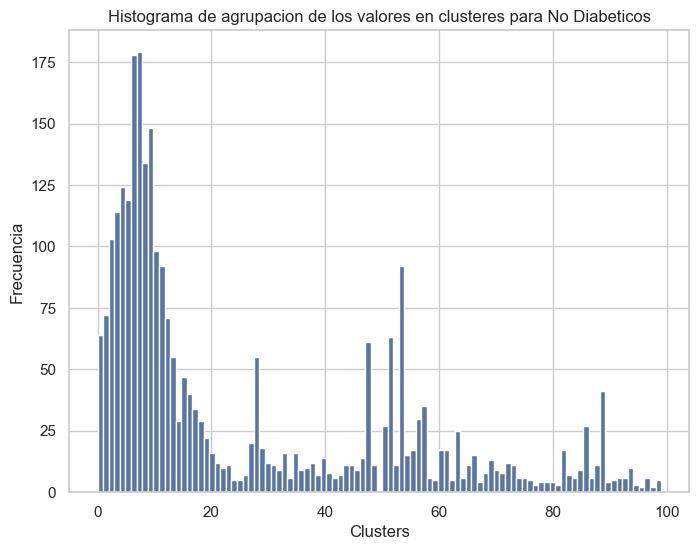

In [68]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 0][clustering_df['cluster_label'] != -1]['cluster_label'] # Quitamos los outliers
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para No Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 0][clustering_df['cluster_label'] != -1],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

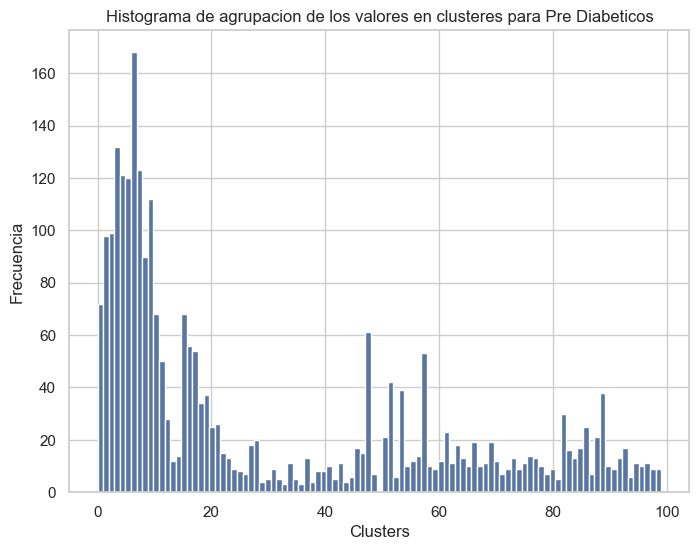

In [69]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 1][clustering_df['cluster_label'] != -1]['cluster_label'] # Quitamos los outliers
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para Pre Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 1][clustering_df['cluster_label'] != -1],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

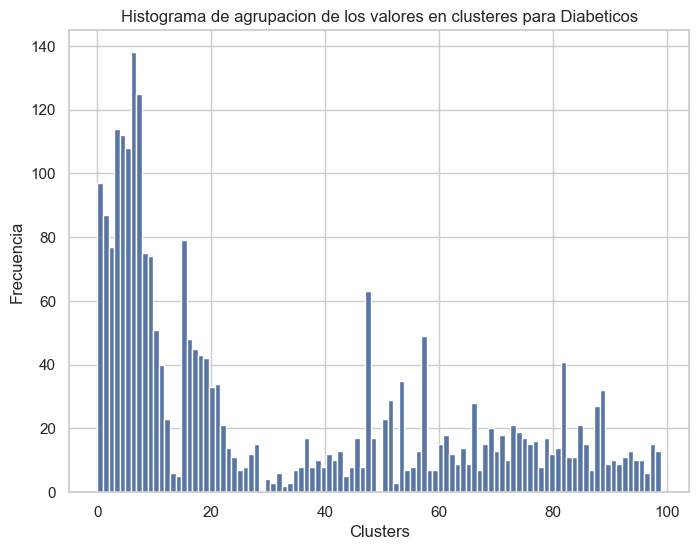

In [70]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 2][clustering_df['cluster_label'] != -1]['cluster_label'] # Quitamos los outliers
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 2][clustering_df['cluster_label'] != -1],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

### 5.7.- Evaluación de calidad

In [71]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

# Indice de silueta
silhouette_avg = silhouette_score(clustering_df, optics_pipeline.named_steps['optics'].labels_)
print("El índice de silueta promedio es:", silhouette_avg)

# Indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(clustering_df, optics_pipeline.named_steps['optics'].labels_)
print("El índice de Davies-Bouldin es:", davies_bouldin)

evaluacion_calidad["optics"] = {"silueta": silhouette_avg, "davies_bouldin": davies_bouldin}

El índice de silueta promedio es: -0.22409647554173692
El índice de Davies-Bouldin es: 4.887898025271002


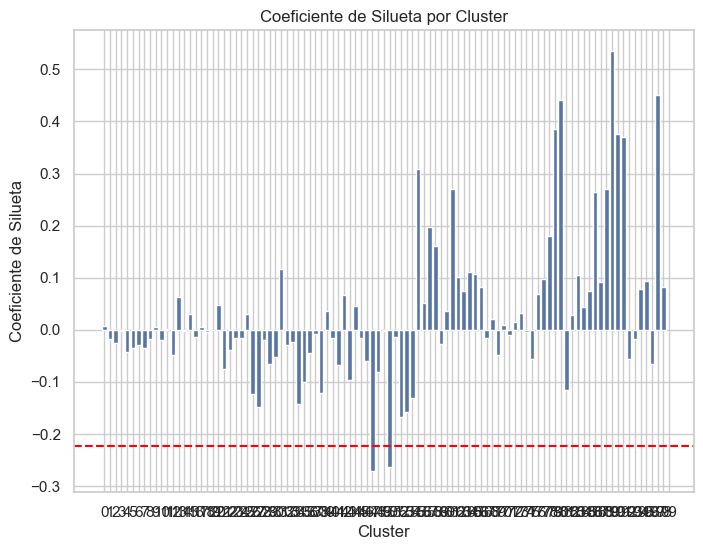

In [72]:
# Calculamos el coeficiente de Silueta promedio
silhouette_avg = silhouette_score(clustering_df, optics_pipeline.named_steps['optics'].labels_)

# Calculamos el coeficiente de Silueta para cada muestra
sample_silhouette_values = silhouette_samples(clustering_df, optics_pipeline.named_steps['optics'].labels_)

# Creamos una lista para almacenar los coeficientes de Silueta promedio por cluster
cluster_silhouette_avg = []

list_siluetes = []
# Creamos un bucle para obtener el coeficiente de Silueta para cada cluster
for cluster in range(max(optics_pipeline.named_steps['optics'].labels_)+1):
    # Obtenemos las muestras pertenecientes al cluster actual
    cluster_silhouette_values = sample_silhouette_values[optics_pipeline.named_steps['optics'].labels_ == cluster]
    
    # Calculamos el coeficiente de Silueta promedio para el cluster actual
    avg_silhouette = np.mean(cluster_silhouette_values)
    
    cluster_dict = {'category': cluster, 'value': avg_silhouette}
    list_siluetes.append(cluster_dict)

    # Almacenamos el coeficiente de Silueta promedio en la lista
    cluster_silhouette_avg.append(avg_silhouette)

cluster_siluetes["optics"] = list_siluetes

# Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_silhouette_avg)-1), cluster_silhouette_avg[1:], color="#5975A4")
plt.title('Coeficiente de Silueta por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(range(len(cluster_silhouette_avg)))
plt.axhline(y=silhouette_avg, color="red", linestyle="--")  # Línea para indicar el valor promedio global de Silueta
plt.show()

### 5.8.- Save Models

In [73]:
joblib.dump(optics_pipeline, 'resultados/trained_models/optics.joblib')

['resultados/trained_models/optics.joblib']

## 6.- DBSCAN  (Basado en el concepto de "Densidad")

### 6.1.- Definición de la pipeline para el DBSCAN

In [74]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

columnas_deseadas = ['MentHlth', 'PhysHlth', 'BMI']
clustering_df = clustering_df.loc[:, columnas_deseadas]

dbscan_pipeline = Pipeline([
    ('MMS', MinMaxScaler()),
    ('dbscan', DBSCAN(eps=0.12, min_samples=2)) 
])

### 6.2.- Entrenamos el modelo con la pipeline y los datos del df

In [75]:
dbscan_pipeline.fit(clustering_df)

Pipeline(steps=[('MMS', MinMaxScaler()),
                ('dbscan', DBSCAN(eps=0.12, min_samples=2))])

### 6.3.- Obtenemos las etiquetas (Cluster al que pertenece) para cada dato

In [76]:
labels = dbscan_pipeline.fit_predict(clustering_df)

### 6.4.- Agregar las etiquetas de clusters y de clasificacion al conjunto de datos

In [77]:
clustering_df["cluster_label"] = labels
clustering_df["diabetic_label"] = df_sampled["Diabetes_012"]

clustering_df.head()
clustering_df.to_csv('resultados/df_clusters/dbscan.csv')

In [78]:
clustering_df.head()

,MentHlth,PhysHlth,BMI,cluster_label,diabetic_label
0,0,0,33,0,0
1,14,0,33,0,0
2,0,0,25,0,0
3,0,0,26,0,0
4,0,1,15,0,0


### 6.5.- Número de clusters encontrados por el algoritmo

In [79]:
# Miramos el número de clusters que el algoritmo ha encontrado
clusters = unique(labels)
print(f"Numero de clusters: {len(clusters) - 1 }")

# Numero de outliers
outlayers = len(clustering_df[clustering_df['cluster_label'] == -1])
print(f"Numero de outlayers: {outlayers}")

Numero de clusters: 4
Numero de outlayers: 15


In [80]:
num_elementos_cluster_label = len(clustering_df[clustering_df['cluster_label'] == 2])

print(f"Número de elementos en el cluster con etiqueta 1: {num_elementos_cluster_label}")

Número de elementos en el cluster con etiqueta 1: 7


### 6.6.- Resumen de pertenencia de clusters por grupo de diabetes

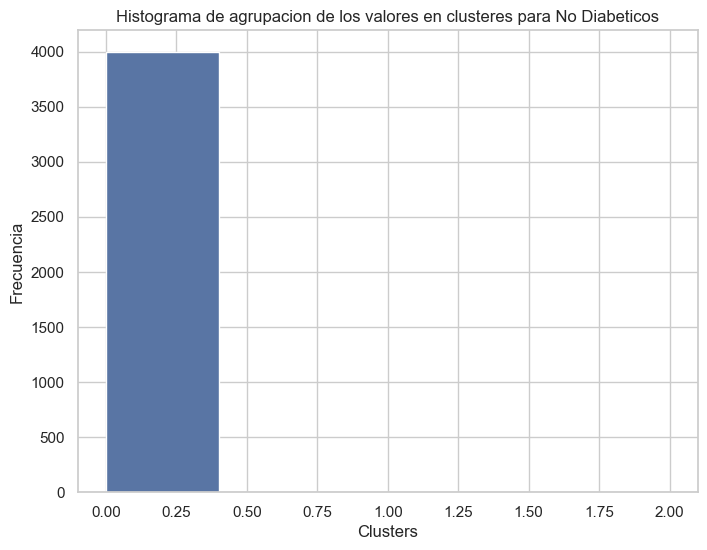

In [81]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 0][clustering_df['cluster_label'] != -1]['cluster_label'] # Quitamos los outliers
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para No Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 0][clustering_df['cluster_label'] != -1],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

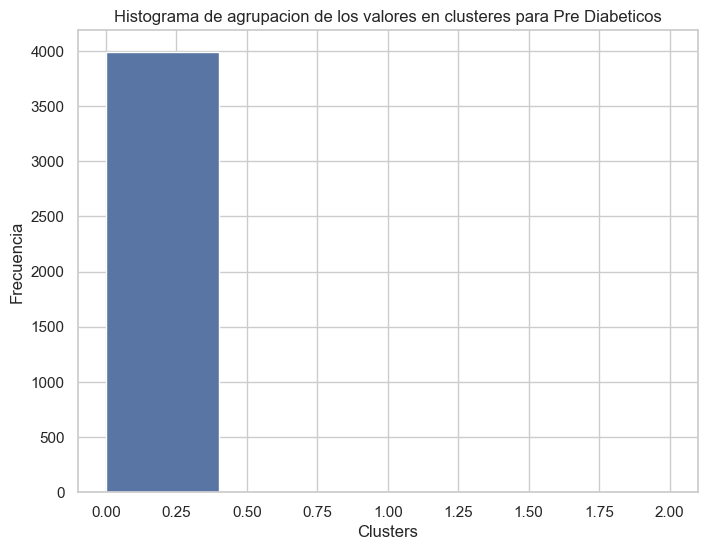

In [82]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 1][clustering_df['cluster_label'] != -1]['cluster_label'] # Quitamos los outliers
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para Pre Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 1][clustering_df['cluster_label'] != -1],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

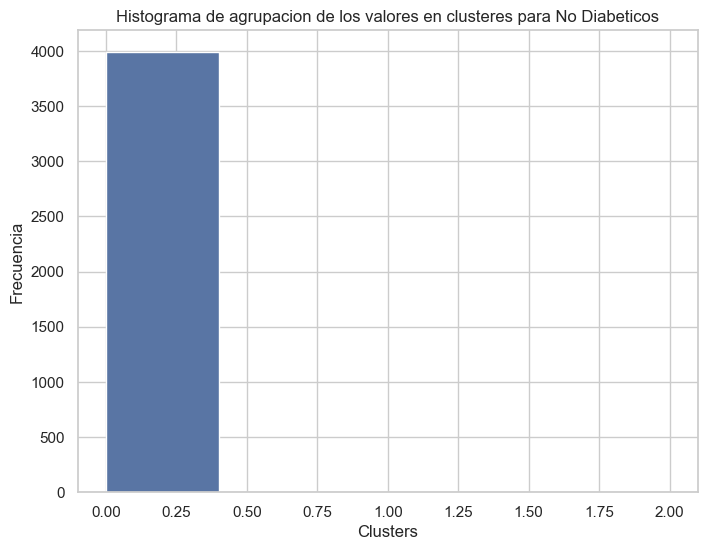

In [83]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 1][clustering_df['cluster_label'] != -1]['cluster_label'] # Quitamos los outliers
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4", bins=len(clusters))
plt.title("Histograma de agrupacion de los valores en clusteres para No Diabeticos")
plt.xlabel("Clusters")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de los valores de cluster_label 
ax= px.treemap(clustering_df[clustering_df['diabetic_label'] == 1][clustering_df['cluster_label'] != -1],path=['cluster_label'],title="Distribución de pacientes en clusteres")
ax.show()

### 6.9.- Evaluación de calidad

In [84]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

# Indice de silueta
silhouette_avg = silhouette_score(clustering_df, dbscan_pipeline.named_steps['dbscan'].labels_)
print("El índice de silueta promedio es:", silhouette_avg)

# Indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(clustering_df, dbscan_pipeline.named_steps['dbscan'].labels_)
print("El índice de Davies-Bouldin es:", davies_bouldin)

evaluacion_calidad["dbscan"] = {"silueta": silhouette_avg, "davies_bouldin": davies_bouldin}

El índice de silueta promedio es: 0.30716259536814916
El índice de Davies-Bouldin es: 0.9247490139934845


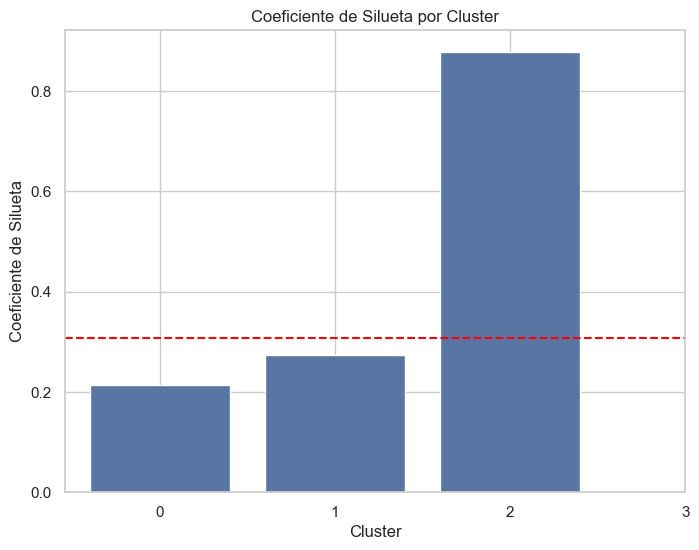

In [85]:
# Calculamos el coeficiente de Silueta promedio
silhouette_avg = silhouette_score(clustering_df, dbscan_pipeline.named_steps['dbscan'].labels_)

# Calculamos el coeficiente de Silueta para cada muestra
sample_silhouette_values = silhouette_samples(clustering_df, dbscan_pipeline.named_steps['dbscan'].labels_)

# Creamos una lista para almacenar los coeficientes de Silueta promedio por cluster
cluster_silhouette_avg = []

list_siluetes = []
# Creamos un bucle para obtener el coeficiente de Silueta para cada cluster
for cluster in range(max(dbscan_pipeline.named_steps['dbscan'].labels_)+1):
    # Obtenemos las muestras pertenecientes al cluster actual
    cluster_silhouette_values = sample_silhouette_values[dbscan_pipeline.named_steps['dbscan'].labels_ == cluster]
    
    # Calculamos el coeficiente de Silueta promedio para el cluster actual
    avg_silhouette = np.mean(cluster_silhouette_values)
    
    cluster_dict = {'category': cluster, 'value': avg_silhouette}
    list_siluetes.append(cluster_dict)

    # Almacenamos el coeficiente de Silueta promedio en la lista
    cluster_silhouette_avg.append(avg_silhouette)

cluster_siluetes["dbscan"] = list_siluetes

# Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_silhouette_avg)-1), cluster_silhouette_avg[1:], color="#5975A4")
plt.title('Coeficiente de Silueta por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(range(len(cluster_silhouette_avg)))
plt.axhline(y=silhouette_avg, color="red", linestyle="--")  # Línea para indicar el valor promedio global de Silueta
plt.show()

In [86]:
with open('resultados/evaluacion_calidad.json', 'w') as archivo_json:
    json.dump(evaluacion_calidad, archivo_json)

with open('resultados/cluster_siluetes.json', 'w') as archivo_json:
    json.dump(cluster_siluetes, archivo_json)

### 6.10.- Save Models

In [87]:
joblib.dump(dbscan_pipeline, 'resultados/trained_models/dbscan.joblib')

['resultados/trained_models/dbscan.joblib']